# 08 — Six-Month Stock Price Forecasts
Generates forward-looking 6-month (126 trading day) ARIMA forecasts with 95% confidence intervals for all 30 stocks in the portfolio.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

from src.data_loader import fetch_multiple_stocks
from src.baselines import ARIMAForecast

warnings.filterwarnings('ignore')
os.makedirs('../figures', exist_ok=True)

## 1. Load Data

In [2]:
TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "JPM", "V", "MA",
           "GS", "JNJ", "UNH", "LLY", "MRK", "ABBV", "XOM", "CVX", "PG", "KO",
           "PEP", "WMT", "HD", "CRM", "AMD", "NFLX", "DIS", "INTC", "BA", "GE"]

stock_data = fetch_multiple_stocks(TICKERS, period='2y')
print(f'Loaded {len(stock_data)} stocks')

Fetching stock data:   0%|          | 0/30 [00:00<?, ?it/s]

Fetching stock data:   3%|▎         | 1/30 [00:00<00:03,  7.82it/s]

Fetching stock data: 100%|██████████| 30/30 [00:00<00:00, 182.62it/s]

Successfully loaded data for 30/30 tickers
Loaded 30 stocks


## 2. Generate 6-Month Forecasts with 95% Confidence Intervals

In [3]:
HORIZON = 126  # ~6 months of trading days
CONTEXT_DAYS = 63  # ~3 months of recent history to show

forecasts = {}

for ticker in TICKERS:
    if ticker not in stock_data:
        continue
    series = stock_data[ticker]['Close']

    model = ARIMAForecast()
    model.fit(series)

    preds, lower, upper = model.predict_with_ci(HORIZON, alpha=0.05)

    # Build future business-day date index
    last_date = series.index[-1]
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=HORIZON)

    forecasts[ticker] = {
        'history': series.iloc[-CONTEXT_DAYS:],
        'dates': future_dates,
        'pred': preds,
        'lower': lower,
        'upper': upper,
    }
    print(f'{ticker}: last=${series.iloc[-1]:.2f}, forecast end=${preds[-1]:.2f} '
          f'[{lower[-1]:.2f}, {upper[-1]:.2f}]')

print(f'\nForecasts generated for {len(forecasts)} stocks')

AAPL: last=$273.44, forecast end=$271.50 [201.72, 341.28]


MSFT: last=$399.88, forecast end=$399.65 [266.09, 533.21]


GOOGL: last=$310.32, forecast end=$310.08 [224.06, 396.11]


AMZN: last=$210.55, forecast end=$210.50 [122.93, 298.07]
NVDA: last=$195.66, forecast end=$194.65 [121.18, 268.11]


META: last=$648.38, forecast end=$648.70 [358.36, 939.03]


TSLA: last=$415.30, forecast end=$414.93 [154.50, 675.35]


JPM: last=$301.68, forecast end=$302.10 [219.92, 384.29]
V: last=$312.98, forecast end=$314.42 [243.38, 385.45]


MA: last=$507.52, forecast end=$513.20 [402.87, 623.52]
GS: last=$919.40, forecast end=$918.22 [669.51, 1166.93]


JNJ: last=$243.96, forecast end=$294.63 [228.48, 360.78]
UNH: last=$281.93, forecast end=$282.90 [23.36, 542.44]


LLY: last=$1035.92, forecast end=$1033.27 [616.13, 1450.40]
MRK: last=$123.00, forecast end=$122.51 [89.91, 155.11]
ABBV: last=$230.66, forecast end=$230.87 [158.10, 303.64]


XOM: last=$147.51, forecast end=$147.57 [113.86, 181.29]
CVX: last=$183.15, forecast end=$183.04 [133.44, 232.64]
PG: last=$162.93, forecast end=$162.80 [128.76, 196.83]


KO: last=$80.11, forecast end=$80.07 [65.76, 94.38]
PEP: last=$167.63, forecast end=$167.64 [124.61, 210.66]


WMT: last=$126.23, forecast end=$126.16 [97.04, 155.28]
HD: last=$371.42, forecast end=$371.51 [256.67, 486.36]


CRM: last=$189.62, forecast end=$189.47 [69.37, 309.57]
AMD: last=$212.28, forecast end=$211.85 [86.60, 337.09]
NFLX: last=$82.04, forecast end=$82.28 [40.57, 123.98]


DIS: last=$105.14, forecast end=$104.99 [61.28, 148.71]
INTC: last=$45.88, forecast end=$45.78 [18.63, 72.92]


BA: last=$230.17, forecast end=$230.09 [135.75, 324.43]
GE: last=$340.71, forecast end=$342.03 [249.77, 434.29]

Forecasts generated for 30 stocks


## 3. Six-Month Forecast Grid — All 30 Stocks

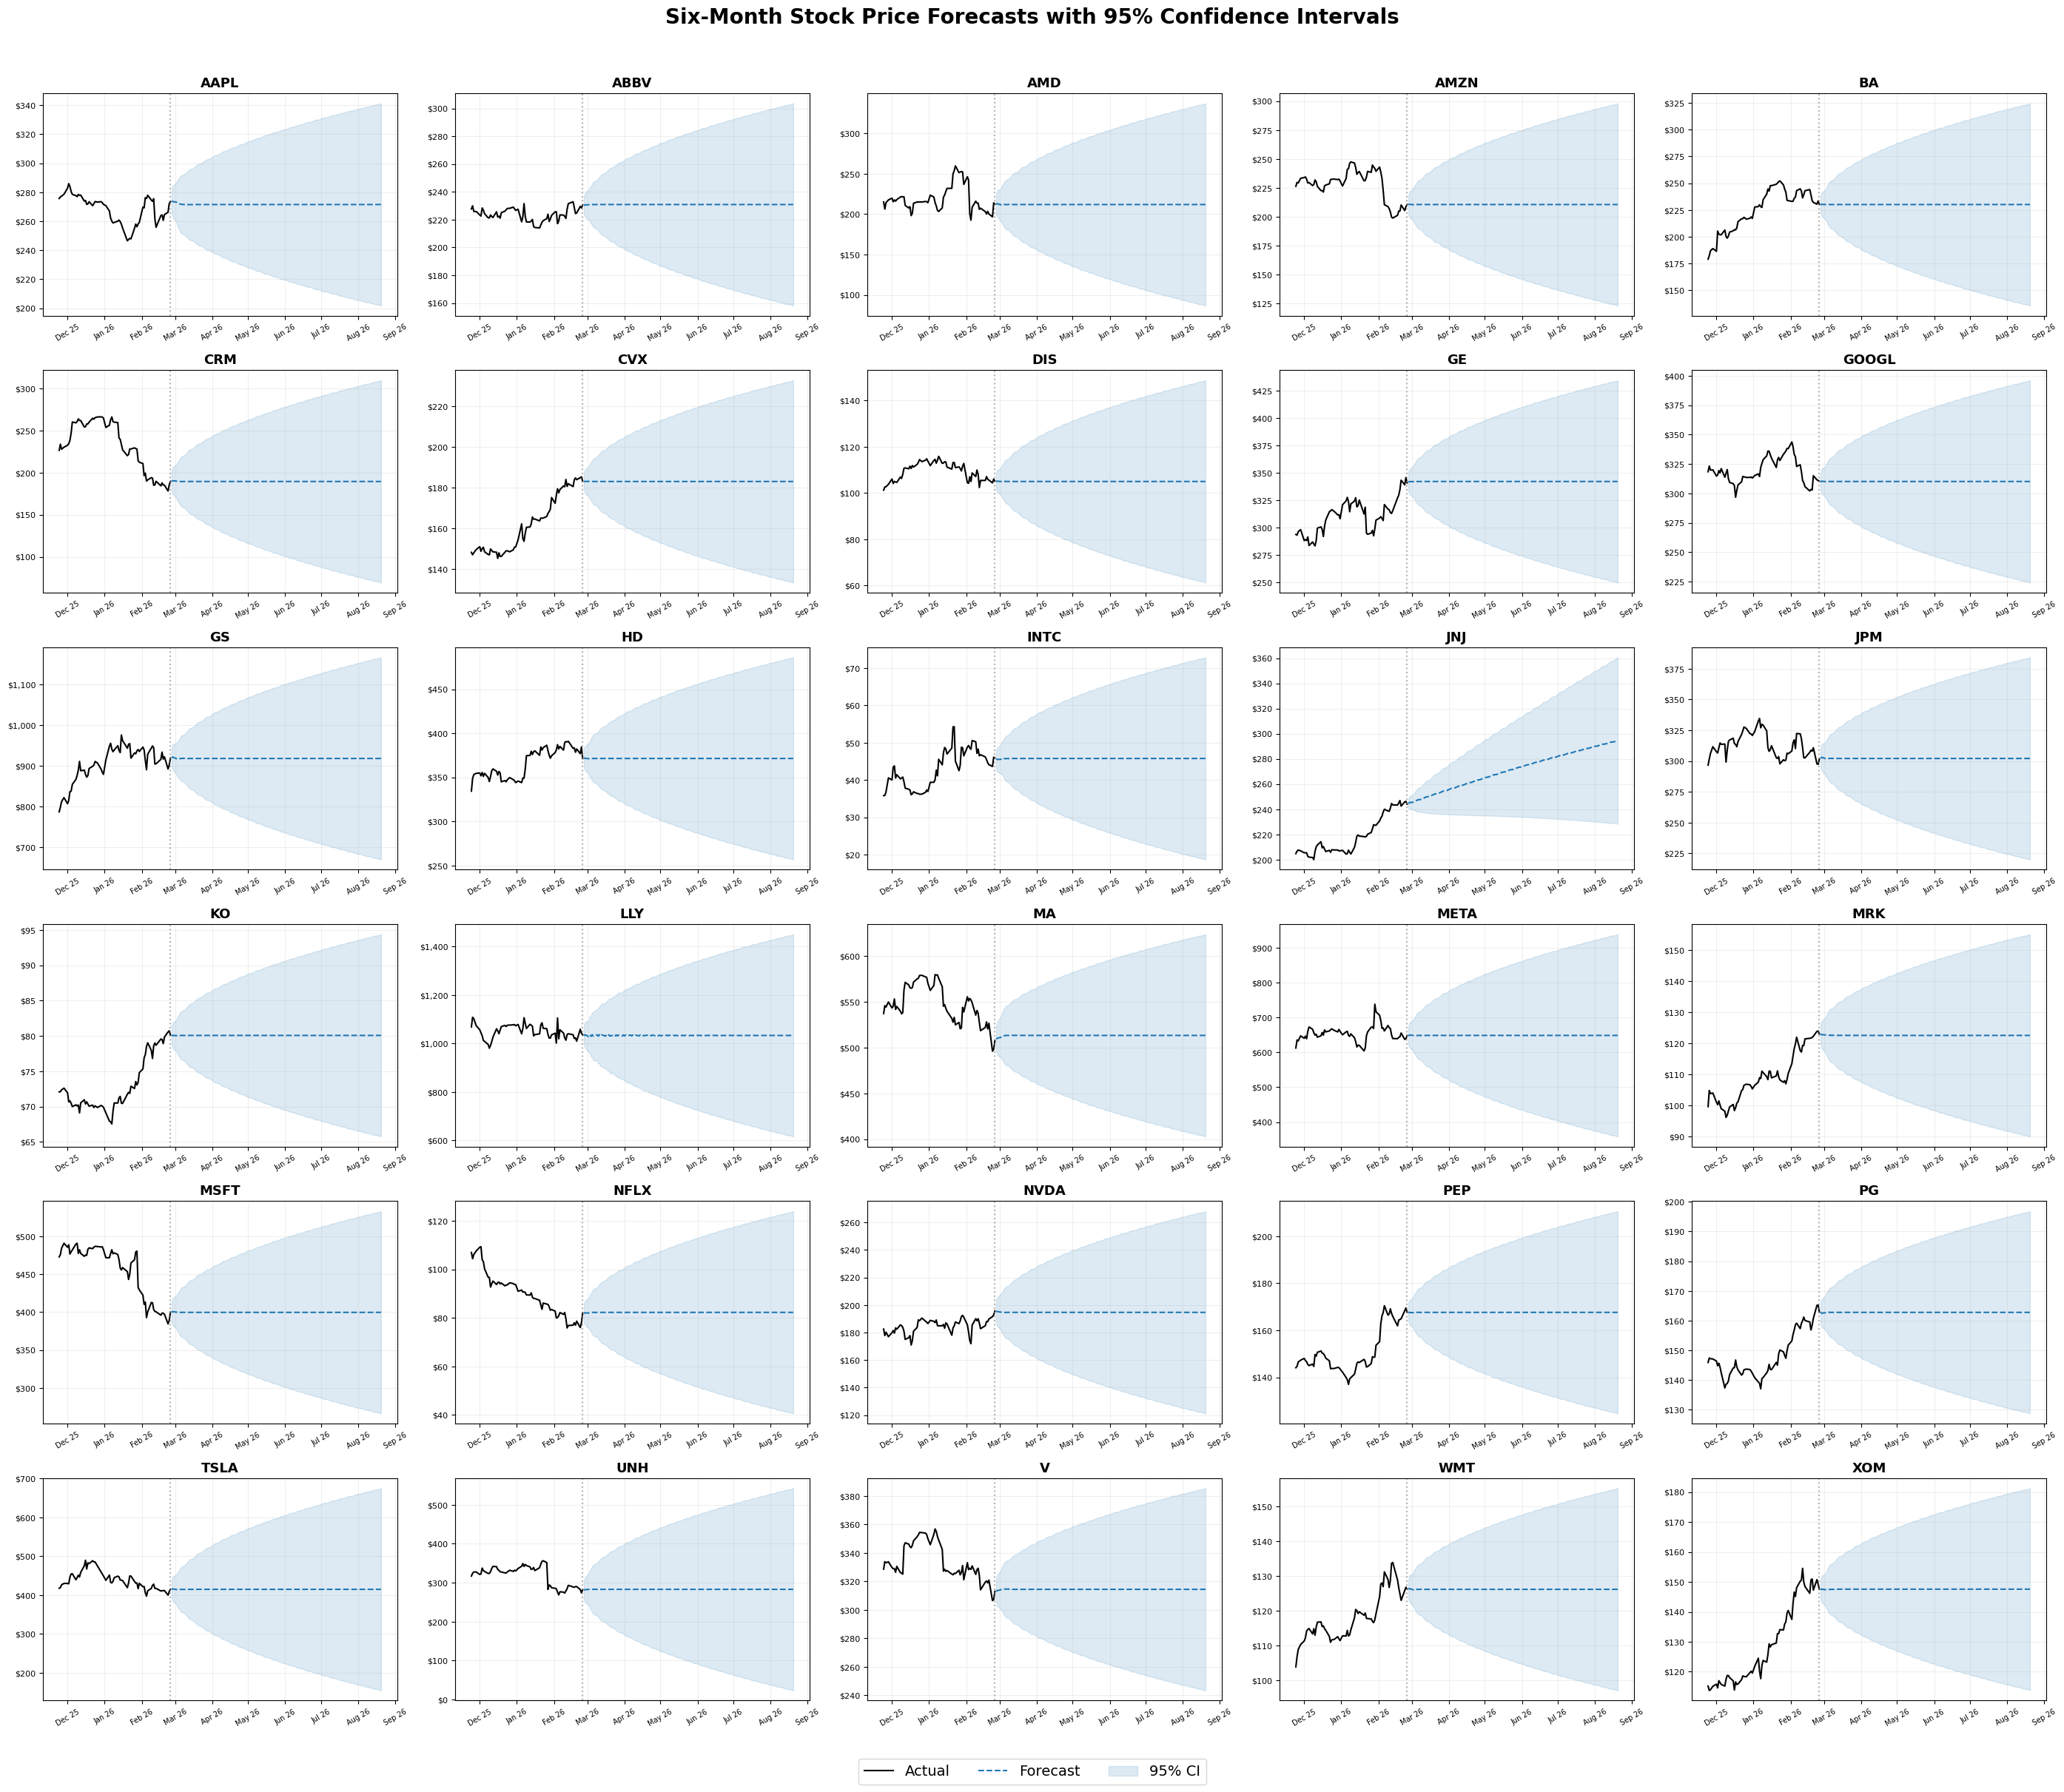

Saved figures/fig7_six_month_forecast.png


In [4]:
n_cols = 5
n_rows = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(28, 24))
fig.suptitle('Six-Month Stock Price Forecasts with 95% Confidence Intervals',
             fontsize=20, fontweight='bold', y=0.995)

sorted_tickers = sorted(forecasts.keys())

for idx, ticker in enumerate(sorted_tickers):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    fc = forecasts[ticker]

    hist = fc['history']
    # Strip timezone for matplotlib compatibility
    hist_dates = hist.index.tz_localize(None) if hist.index.tz else hist.index
    future_dates = fc['dates'].tz_localize(None) if fc['dates'].tz else fc['dates']

    # Plot recent history
    ax.plot(hist_dates, hist.values, color='black', linewidth=1.5, label='Actual')

    # Plot forecast
    ax.plot(future_dates, fc['pred'], color='#1f77b4', linewidth=1.5, linestyle='--', label='Forecast')

    # 95% CI band
    ax.fill_between(future_dates, fc['lower'], fc['upper'],
                    color='#1f77b4', alpha=0.15, label='95% CI')

    # Vertical line at forecast start
    ax.axvline(x=hist_dates[-1], color='gray', linestyle=':', alpha=0.6)

    ax.set_title(ticker, fontsize=13, fontweight='bold')
    ax.tick_params(axis='x', rotation=30, labelsize=7)
    ax.tick_params(axis='y', labelsize=8)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
    ax.grid(True, alpha=0.2)

# Hide unused subplots
for idx in range(len(sorted_tickers), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row, col].set_visible(False)

# Single legend at bottom
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=14,
           bbox_to_anchor=(0.5, -0.01))

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.savefig('../figures/fig7_six_month_forecast.png', dpi=200, bbox_inches='tight')
plt.show()
print('Saved figures/fig7_six_month_forecast.png')